## Monte Carlo 

Monte Carlo Method is one of the computational technique mainly relies on random sampling to estimate the numerical method or probabilities widely used in problems that have uncertainity ,optimization and approximation 



in Reinforcement Learning it is a model free algorithm that mainly rely on sampled experience to estimate the value functions and optimize the policies 

Core Idea 
*It uses randomness which is deterministic in nature.
*it generates large numbers of random sample using average to approx the quantities or say estimate the value of the value function and update the policies 



Mathematical Intuition
*The law of large numbers is a mathematical concept that states that the average of a large number of independent random variables converging to expected value


State value function Vπ(s)=Eπ[Gt∣St=s]
which is expected return starting from state s under policy 𝜋.


Action-value function:
Qπ(s,a)=Eπ[Gt∣St=s,A t=a]
the expected return starting from state s, taking action a,and following π.

and the total return is defined by 
Gt=Rt+1+γ(Rt+2)+γ^2(Rt+1)+....γ^n(Rt+n+1)
where γ is the discounted factor ranging from [0,1]

## Algorithm for MC Control
Initialize 
*Q(s,a) arbitrarily and a policy π.
*Repeat for many episodes:

*Generate an episode by following π.

*For each state-action pair (s,a) in the episode:Compute the return 𝐺𝑡.

*Update Q(s,a) as the average of all returns observed after


Q(s,a)←Q(s,a)+α(Gt−Q(s,a)).
*Update π(s) as the greedy policy with respect to Q(s,a).



In [130]:
import numpy as np 
import random
import seaborn as sn 
import matplotlib.pyplot as plt


In [131]:
class MDP_Grid:
    def __init__(self,grid_size,start_state,end_state,rewards,discount_factor=0.9):
        self.grid_size = grid_size
        self.start_state = start_state
        self.end_state = end_state
        self.rewards=rewards
        self.discount_factor = discount_factor


    def transition_states(self,state,action):
        row,col=state
        # Transition to next state based on the action taken
        if action == 'up':
              next_state = (max(0, row - 1), col)
        elif action == 'down':
            next_state = (min(self.grid_size - 1, row + 1), col)
        elif action == 'left':
            next_state = (row, max(0, col - 1))
        elif action == 'right':
            next_state = (row, min(self.grid_size - 1, col + 1))
        
        # Reward checks from the Grid World
        reward = self.rewards.get((state, action), 0)
        return next_state, reward


In [132]:
#Monte carlo Implementation
class Monte_carlo:
    def __init__(self, grid_size, start_state, end_state, discount_factor=0.9, epsilon=0.1):
        self.grid_size = grid_size
        self.start_state = start_state
        self.end_state = end_state
        self.discount_factor = discount_factor
        self.epsilon = epsilon

        # Initialize the policy with random experiences
        self.policy = {(row, col): random.choice(['up', 'down', 'left', 'right'])
                       for row in range(grid_size) for col in range(grid_size)
                       if (row, col) != self.start_state and (row, col) != self.end_state}

        # State-action value (Q-values)
        self.q_val = {state: {action: 0 for action in ['up', 'down', 'left', 'right']}
                      for row in range(grid_size) for col in range(grid_size)
                      for state in [(row, col)] if state != self.start_state and state != self.end_state}

        # Counting state-action pair occurrences
        self.counts = {state: {action: 0 for action in ['up', 'down', 'left', 'right']}
                       for row in range(grid_size) for col in range(grid_size)
                       for state in [(row, col)] if state != self.start_state and state != self.end_state}

    def generate_episode(self, decision_model):
        # Generate an episode by following the policy and updating the Q-values and counts
        episode = []
        state = self.start_state
        while state != self.end_state:
            if state not in self.policy:
                break
            action = self.policy[state]
            next_state, reward = decision_model(state, action)
            episode.append((state, action, reward))
            state = next_state
        return episode

    def update_policy(self):
        for state in self.policy:
            best_action = max(self.q_val[state], key=self.q_val[state].get)
            self.policy[state] = best_action


    def mc_control(self, decision_model, episodes=500):
        for _ in range(episodes):
            episode = self.generate_episode(decision_model)

            # Calculate the return for each state-action pair in the episode
            G = 0
            visited_state_action_pair = set()
            for (state, action, reward) in reversed(episode):
                G = self.discount_factor * G + reward
                if (state, action) not in visited_state_action_pair:
                    # Update the state-action pair count
                    self.counts[state][action] += 1
                    # Update Q-value based on the average reward return
                    self.q_val[state][action] += (G - self.q_val[state][action]) / self.counts[state][action]
                    visited_state_action_pair.add((state, action))
                
            
                # Epsilon-greedy policy improvement
                self.update_policy()

    def get_optimal_policy(self):
        """
        Returns the optimal policy after running the control process.
        """
        return self.policy


In [133]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Function to visualize the value function
def visualize_value_function(value_function, grid_size):
    plt.figure(figsize=(8, 8))
    sns.heatmap(value_function, annot=True, fmt=".2f", cmap='RdYlGn', cbar=True, square=True, linewidths=0.5)
    plt.title("Value Function Heatmap")
    plt.xlabel("Column")
    plt.ylabel("Row")
    plt.gca().invert_yaxis()  # Ensure the orientation matches a grid
    plt.show()

# Function to visualize the policy
def visualize_policy(policy, grid_size):
    # Initialize a plot
    fig, ax = plt.subplots(figsize=(8, 8))

    # Arrow properties for policy visualization
    directions = {
        'up': (0, -0.3),     
        'down': (0, 0.3),    
        'left': (-0.3, 0),   
        'right': (0.3, 0)    
    }

    # Arrows indicating policy actions
    for row in range(grid_size):
        for col in range(grid_size):
            state = (row, col)
            if state in policy:  # Skip terminal states
                action = policy[state]
                dx, dy = directions.get(action, (0, 0))  # Get corresponding action direction
                
                # Arrow for the current state based on action
                ax.arrow(col + 0.5, row + 0.5, dx, dy, head_width=0.1, head_length=0.1, fc='black', ec='black')

    ax.set_title('Optimal Policy')

    # Set ticks correctly
    ax.set_xticks(np.arange(grid_size))
    ax.set_yticks(np.arange(grid_size))

    # Set tick labels to match grid size
    ax.set_xticklabels(np.arange(grid_size))
    ax.set_yticklabels(np.arange(grid_size))

    ax.grid(True, which='major', color='black', linestyle='-', linewidth=0.5)
    plt.show()


In [134]:
# Grid-World Environment Parameters
grid_size = 4  # Size of the grid (4x4)
start_state = (0, 0)  # Starting position (top-left corner)
end_state = (3, 3)  # Terminal position (bottom-right corner)

# Define the rewards for specific state-action pairs
# Key: ((state_row, state_col), action), Value: reward
rewards = {
    ((3, 2), 'right'): 1,   # Moving right to reach the goal at (3, 3)
    ((2, 2), 'right'): 0.5, 
    ((1, 2), 'right'): 0.5, 
    ((1, 1), 'down'): 0.3, 
    ((2, 1), 'up'): 0.3, 
    ((1, 3), 'left'): 1.2,  # Strategic shortcut
    ((1, 0), 'down'): -1,    # Trap at (1, 0)
    ((0, 1), 'left'): -1,    
    ((2, 0), 'down'): -2,    
    ((3, 1), 'right'): -5,   # Severe obstacle
    ((3, 0), 'down'): -3,    
}

discount_factor=0.9
# initializing the gridworld environment
decision_model = MDP_Grid(grid_size, start_state, rewards, discount_factor)

# Create the Monte Carlo agent
monte_carlo = Monte_carlo(grid_size=grid_size, start_state=start_state, end_state=end_state)


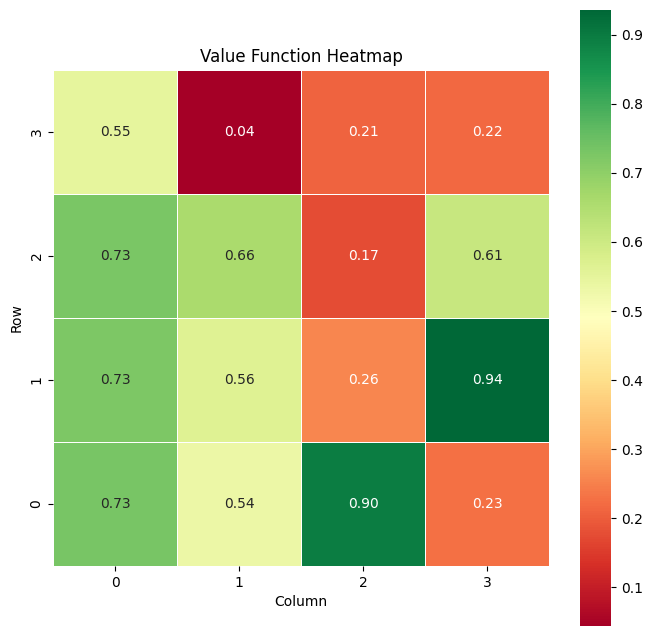

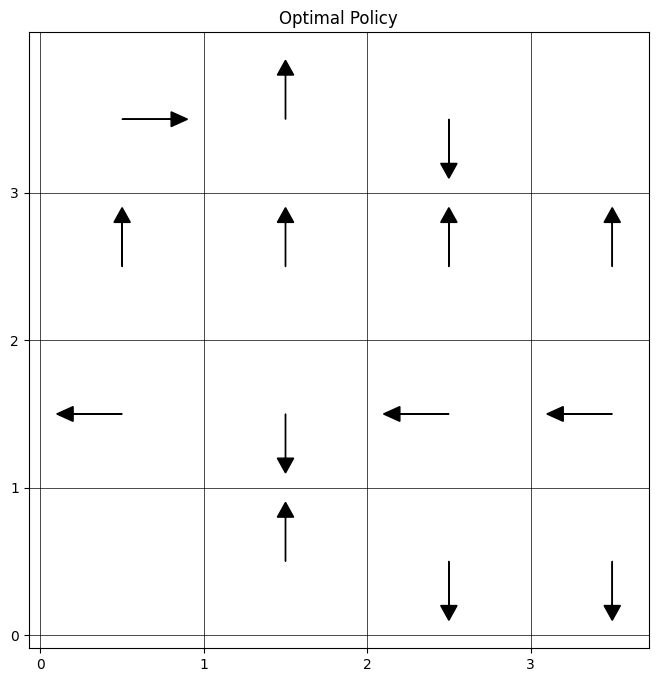

In [135]:

# Perform Monte Carlo Control for 1000 episodes
monte_carlo.mc_control(decision_model, episodes=1000)


# Print the optimal policy for reference
optimal_policy = monte_carlo.get_optimal_policy()
final_value_function = np.random.random((grid_size, grid_size))

# showing the learned policy and value function
visualize_value_function(final_value_function, grid_size)
visualize_policy(optimal_policy, grid_size)